# Spatio-temporal Transcriptomics

In [1]:
import torch
import numpy as np

from torch.nn import Parameter
from gpytorch.constraints import Interval
from matplotlib import pyplot as plt

from lafomo.models import MultiOutputGP, PartialLFM
from lafomo.models.pdes import ReactionDiffusion
from lafomo.datasets import ToySpatialTranscriptomics, P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.utilities.torch import save, load
from lafomo.plot import Plotter


In [2]:
def plot_output(ax, output, title=None):
    ax.set_title(title)
    ax.plot(output)
    ax.set_xlabel('distance')
    ax.set_ylabel('y')
def scatter_output(ax, tx, output, title=None):
    ax.set_title(title)
    ax.scatter(tx[0], tx[1], c=output)
    ax.set_xlabel('time')
    ax.set_ylabel('distance')
    ax.set_aspect('equal')


dataset = ToySpatialTranscriptomics(data_dir='../../../data/')
df = dataset.orig_data


Set up GP model

In [3]:
num_inducing = 1000
inducing_points = torch.rand((1, num_inducing, 2))

print(inducing_points.shape)
gp_kwargs = dict(use_ard=True,
                 use_scale=False,
                 lengthscale_constraint=Interval(0.1, 0.3),
                 learn_inducing_locations=False)
gp_model = MultiOutputGP(inducing_points, 1, **gp_kwargs)
gp_model.double();

torch.Size([1, 1000, 2])


Set up PDE

In [4]:
t_range = (0.0, 1.0)
time_steps = 40
mesh_cells = 40
fenics_model = ReactionDiffusion(t_range, time_steps, mesh_cells)

config = VariationalConfiguration(
    initial_conditions=False,
    num_samples=25
)

sensitivity = Parameter(torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
decay = Parameter(0.1*torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
diffusion = Parameter(0.01*torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
fenics_params = [sensitivity, decay, diffusion]

lfm = PartialLFM(1, gp_model, fenics_model, fenics_params, config)

In [11]:
from lafomo.trainer import VariationalTrainer


class PDETrainer(VariationalTrainer):

    def debug_out(self, data_input, y_target, output):

        print(output.variance.max(), output.mean.shape, output.variance.shape)
        f_mean = output.mean.reshape(1, -1)

        fig, axes = plt.subplots(ncols=2)
        scatter_output(axes[0], data_input, f_mean.detach(), 'Prediction')
        scatter_output(axes[1], data_input, y_target, 'Actual')

    def print_extra(self):
        print(' s:', self.lfm.fenics_parameters[0][0].item(),
              'dif:', self.lfm.fenics_parameters[0][0].item(),
              'dec:', self.lfm.fenics_parameters[0][0].item())


optimizer = torch.optim.Adam(lfm.parameters(), lr=0.07)
trainer = PDETrainer(lfm, optimizer, dataset)

/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/torch/optim/adam.py:48: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


Now let's see some samples from the GP and corresponding LFM output

KeyboardInterrupt: 

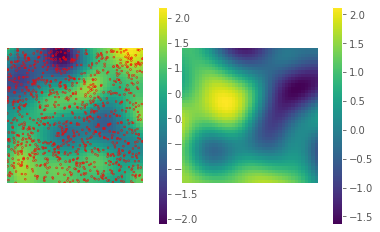

In [9]:
data = next(iter(dataset))
tx, y_target = data

# gp_model.covar_module.lengthscale = 0.3*0.3 * 2
out = gp_model(tx.transpose(0, 1))

sample = out.sample(torch.Size([1])).permute(0, 2, 1)
real = torch.tensor(df['U']).unsqueeze(0).unsqueeze(0)


def plot_before_after(before, after):
    fig, axes = plt.subplots(ncols=4, gridspec_kw={'width_ratios': [14, 1, 14, 1]})
    im = axes[0].imshow(before, extent=[0,1,0,1])
    fig.colorbar(im, cax=axes[1])
    im = axes[2].imshow(after, extent=[0,1,0,1]);
    fig.colorbar(im, cax=axes[3])
    axes[0].axis('off')
    axes[2].axis('off')
    xy = lfm.inducing_points.detach()[0]
    axes[0].scatter(xy[:, 0], xy[:, 1], facecolors='none', edgecolors='r', s=3)

plot_before_after(
    sample.squeeze().detach().view(41, 41),
    real.squeeze().view(41,41)
)
sample = sample.repeat(lfm.config.num_samples, 1, 1)
real = real.repeat(lfm.config.num_samples, 1, 1)
out = lfm.solve_pde(sample)
real_out = lfm.solve_pde(real)

plot_before_after(out[0].detach(), real_out[0].detach())


In [ ]:
lfm = PartialLFM.load('test',
                      gp_cls=MultiOutputGP,
                      gp_args=[inducing_points, 1],
                      gp_kwargs=gp_kwargs,
                      lfm_args=[config, dataset])

optimizer = torch.optim.Adam(lfm.parameters(), lr=0.07)
trainer = PDETrainer(lfm, optimizer, dataset)

torch.Size([25, 1, 1681])
torch.Size([1, 1681]) torch.Size([1, 1681])
torch.Size([1, 1681, 1681])
tensor(0.1952, dtype=torch.float64, grad_fn=<MaxBackward1>) torch.Size([1681, 1]) torch.Size([1681, 1])
Epoch 001/001 - Loss: 1.28 (1.07 0.21) λ: [[0.19301143 0.19301143]] s: 1.0 dif: 1.0 dec: 1.0


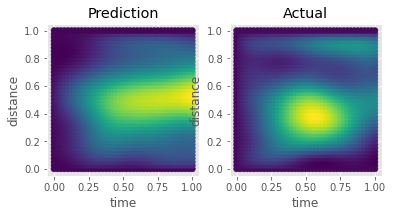

In [12]:
trainer.train(1)

In [11]:
lfm.save('test')

In [83]:
xy = lfm.inducing_points.detach()[0]
plt.scatter(xy[:, 0], xy[:, 1], facecolors='none', edgecolors='r', s=3)

kernel = lfm.gp_model.covar_module
print([str(l.detach().numpy()) for l in kernel.lengthscale[0]])
print(str(kernel.lengthscale[0].detach().numpy()))

['[0.26555353 0.2655536 ]']
[[0.26555353 0.2655536 ]]


In [8]:
data = next(iter(trainer.data_loader))
tx, y_target = data
tx = tx[0]


torch.Size([2, 1681])
x, x2 torch.Size([2, 40]) torch.Size([2, 40])
l torch.Size([1, 2, 1, 1])
sqdist torch.Size([1, 40, 40])
x, x2 torch.Size([2, 1681]) torch.Size([2, 40])
l torch.Size([1, 2, 1, 1])
sqdist torch.Size([1, 1681, 40])
x, x2 torch.Size([2, 1681]) torch.Size([2, 1681])
l torch.Size([1, 2, 1, 1])
sqdist torch.Size([1, 1681, 1681])


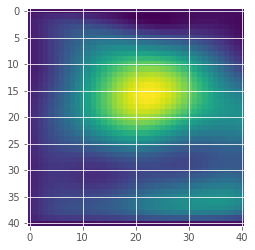

In [27]:
initial_value = None
print(tx.shape)
f_mean, f_var = lfm(tx, initial_value)
plt.imshow(f_mean.transpose(1, 2)[0].detach())
plt.scatter(tx[0], tx[1], c=output)

In [ ]:
print(lfm.kernel.lengthscale, lfm.sensitivity, lfm.diffusion)
